In [27]:
#######################################################################
# MSDS 442: AI Agent Design and Development
# Spring '25
# Dr. Bader
#
# Final Project: AI Agent Automation for Peloton’s Fitness Ecosystem
# Phase 2 - Prototype
# 
# Kevin Geidel
#
#######################################################################

# OBJECTIVE:
#   Construct a high-fidelity prototype of the Peloton Automation. 
#   Implement the planned architecture using Phase 1 Artifacts.

# Load environment variables
from dotenv import load_dotenv
load_dotenv()

# Python native imports
import os, inspect, textwrap, time, sys
from typing import Annotated, Sequence

# LangChain/LangGraph imports
from langchain_core.messages import BaseMessage, HumanMessage, SystemMessage
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_community.document_loaders import JSONLoader
from langchain.tools.retriever import create_retriever_tool
from langchain.embeddings.sentence_transformer import SentenceTransformerEmbeddings
os.environ['USER_AGENT'] = 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'
__import__('pysqlite3')
sys.modules['sqlite3'] = sys.modules.pop('pysqlite3')
from langchain_community.vectorstores import Chroma
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import ToolNode, tools_condition

# 3rd party package imports
from IPython.display import display, Image
from typing_extensions import TypedDict


class PelotonAgent:
    ''' Namespace for methods and metaclasses that facilliate Peloton's Agent-based automation. '''

    class InquiryState(TypedDict):
        inquiry: str
        response: str
        referring_node: str
        next_node: str
        messages: Annotated[Sequence[BaseMessage], "List of messages in the conversation"]

    def __init__(self):
        # Assign agent-wide variables
        self.model_name = 'gpt-4o-mini'
        self.data_dir = os.path.join('src')
        self.agent_data_path = os.path.join(self.data_dir, 'ai_agent_test_data.json')        
        
        # Establish the AI client
        self.llm = ChatOpenAI(model=self.model_name, temperature=0)

        # Load test data into memory in form of langchain docs
        self.load_documents()

        # Initialize ChromaDb vector store and load docs
        self.populate_vector_store()

        # Construct the agent graph
        self.build_graph()

    def load_documents(self):
        loader = JSONLoader(
            file_path=self.agent_data_path, 
            jq_schema='.',
            text_content=False,
        )
        self.data= loader.load()

    def populate_vector_store(self):
        if not hasattr(self, 'db'):
            self.db = Chroma.from_documents(
                documents=self.data, 
                collection_name='test_data',
                embedding=OpenAIEmbeddings()
            )
    
    def get_retriever_tool(self):
        return create_retriever_tool(
            self.db.as_retriever(),
            'retrieve_peloton_data',
            """Search Peloton Enterprise data in the vector store and return information for:
                - Order and Shipping information
                - Product catalog information
                - Marketing campaign metrics
                - Membership account information
                - Data Science metrics"""
        )

    def build_graph(self):
        builder = StateGraph(self.InquiryState)
        # nodes
        builder.add_node('Router', self.router_agent)
        builder.add_node('Marketing', self.marketing_agent)
        builder.add_node('DataScience', self.data_science_agent)
        builder.add_node('MembershipAndFraudDetection', self.membership_agent)
        builder.add_node('Orders', self.orders_agent)
        builder.add_node('Recommendations', self.recommendation_agent)
        retriever_tool = ToolNode([self.get_retriever_tool()])
        builder.add_node("Retrieve", retriever_tool)
        # edges/workflow
        builder.add_edge(START, 'Router')
        builder.add_conditional_edges(
            'Router',
            lambda x: x['next_node'],
        )
        for node in ['Marketing', 'DataScience', 'MembershipAndFraudDetection', 'Orders', 'Recommendations']:
            builder.add_conditional_edges(
                node, 
                tools_condition,
                {
                    'tools': 'Retrieve',
                    END: END,
                }
            )
        
        self.graph = builder.compile(checkpointer=MemorySaver())

    def draw_graph(self):
        display(Image(self.graph.get_graph().draw_mermaid_png()))
    
    # base methods for agents
    def termination_check(self, state):
        ''' Check for user end session '''
        inquiry = state.get('inquiry', '')
        if inquiry.lower() in ['q', 'quit', 'goodbye', 'bye']:
            return {
                "inquiry": inquiry,
                "referring_node": state.get('next_node', 'Router'),
                "next_node": END,
                "response": "Goodbye! Thank you for contacting the Peloton automated AI agent!",
                "messages": state.get('messages', []) + [HumanMessage(content=inquiry), SystemMessage(content="Conversation ended by user.")]            
            }
        else:
            return None
    
    def route_ongoing_chat(self, state, max_history=5):
        inquiry = state.get('inquiry', '')
        messages = state.get("messages", [])
        if state.get('referring_node') != "Router" and state.get('next_node'):
            history = "\n".join([f"{msg.type}: {msg.content}" for msg in state.get("messages", [])][:max_history])
            query = f"""Given the conversation history and the new inquiry: '{inquiry}', determine if this is a follow-up question related to the previous department ({state['referring_node']}) or a new topic. Return 'continue' if it's a follow-up, or classify the intent for a new topic.
            Possible intent values: Greeting, GeneralInquiry, Marketing, DataScience, MembershipAndFraudDetection, Orders, Recommendations
            
            Conversation history:
            {history}
            """
            messages_for_intent = [
                SystemMessage(content="You are a helpful assistant tasked with classifying the intent of a user's query or detecting follow-ups."),
                HumanMessage(content=[{'type': 'text', 'text': query}])
            ]
            response = self.llm.invoke(messages_for_intent)
            intent = response.content.strip()
            if intent == 'continue':
                return {
                    "inquiry": state["inquiry"],
                    "referring_node": "Router",
                    "next_node": state['referring_node'],
                    "response": f"Routing to the {state['referring_node']} department.",
                    "messages": messages + [HumanMessage(content=inquiry)]            
                }
        return {}    

    def unimplemented_agent(self, state):
        calling_agent = inspect.currentframe().f_back.f_code.co_name
        return {
            'inquiry': state['inquiry'],
            'response': f'{calling_agent} is not yet implemented.',
            'referring_node': state.get('referring_node', None),
            'next_node': END,
            'messages': state.get('messages', []) + [SystemMessage(content=f'Routed to unimplented agent, {calling_agent}.')]
        }

    # define agents methods
    def router_agent(self, state):
        inquiry = state.get('inquiry', '')
        messages = state.get('messages', [])

        # check for termination by user
        terminate = self.termination_check(state)
        if terminate:
            return terminate
        
        # check for ongoing conversation
        ongoing = self.route_ongoing_chat(state)
        if ongoing:
            return ongoing
    
        # Classify intent for this new session and route
        query = f"""Classify the user's intents based on the following input: '{inquiry}'. 
                List of possible intent values: Greeting, GeneralInquiry, Marketing, DataScience, MembershipAndFraudDetection, Orders, Recommendations
                Return only the intent value of the inquiry identified with no extra text or characters"""
        messages = [
            SystemMessage(content="You are a helpful assistant tasked with classifying the intent of user's inquiry"),
            HumanMessage(content=[{"type": "text", "text": query}]),
        ]
        response = self.llm.invoke(messages)
        intent = response.content.strip()
        response_lower = intent.lower()
        
        if "greeting" in response_lower:
            response = "Hello there, this is the Peloton automated AI agent. How can I assist you today?"
            next_node = END
        elif "generalinquiry" in response_lower:
            response = "For general informtion about Peloton's ecosystem of classes and products visit https://www.onepeloton.com/. Thank you!"
            next_node = END
        else:
            response = f"Let me forward your query to our {intent} agent."
            next_node = intent

        return {
            "inquiry": state["inquiry"],
            "referring_node": "Router",
            "next_node": next_node,
            "response": response,
            'messages': messages + [SystemMessage(content=intent)]
        }       

    def marketing_agent(self, state):
        # Target use cases:
        #   1) Query customer data via vector DB; use retrieval to analyze and return top segments.
        inquiry = state.get('inquiry', '')
        messages = state.get("messages", [])
        history = "\n".join([f'{msg.type}: {msg.content}' for msg in messages][:5])
        marketing_agent_human_message = HumanMessage(
            content = f"""Provide an answer for the following user's inquiry: 
            '{inquiry}'

            Conversation history for content:
            {history}
            """.strip()
        )
        if state['referring_node'] == 'Router':
            marketing_agent_system_message = SystemMessage(
                content = f"""You are a helpful assistant tasked with retrieving and organizing data to answer questions about ongoing marketing campaigns.
                If the inquiry relates to data found in the agent database, base answers solely on the records within: {str(self.data)}"""
            )
            messages += [marketing_agent_system_message, marketing_agent_human_message]
        else:
            messages += [marketing_agent_human_message]

        # query the llm
        response = self.llm.invoke(messages)

        return {
            'inquiry': inquiry,
            'referring_node': 'Marketing',
            'next_node': tools_condition(state),
            'response': response,
            'messages': messages + [SystemMessage(content=response.content.strip())]
        }
    
    def data_science_agent(self, state):
        return self.unimplemented_agent(state)
    
    def membership_agent(self, state):
        return self.unimplemented_agent(state)
    
    def orders_agent(self, state):
        return self.unimplemented_agent(state)
    
    def recommendation_agent(self, state):
        return self.unimplemented_agent(state)
    
    def invoke(self, thread_id="1"):
        config = {"configurable": {"thread_id": thread_id}}
        while True:
            user_input = input("User: ")
            time.sleep(0.5)
            print(f"User:\n  {user_input}")
            time.sleep(0.5)
            if user_input.lower() in {"q", "quit"}:
                print("Goodbye!")
                break
            result = self.graph.invoke({"inquiry": user_input}, config=config)
            time.sleep(0.5)
            response = result.get("response", "No Response Returned")
            print('Agent:\n ', textwrap.fill(response.content, 80))       

bot = PelotonAgent()


In [28]:
bot.invoke()



User:
  What is the highest performing marketing campaing?
Agent:
  The highest performing marketing campaign is the "Black Friday" campaign, which
has a Click Rate of 7.1 and a Conversion Rate of 3.5.
User:
  q
Goodbye!


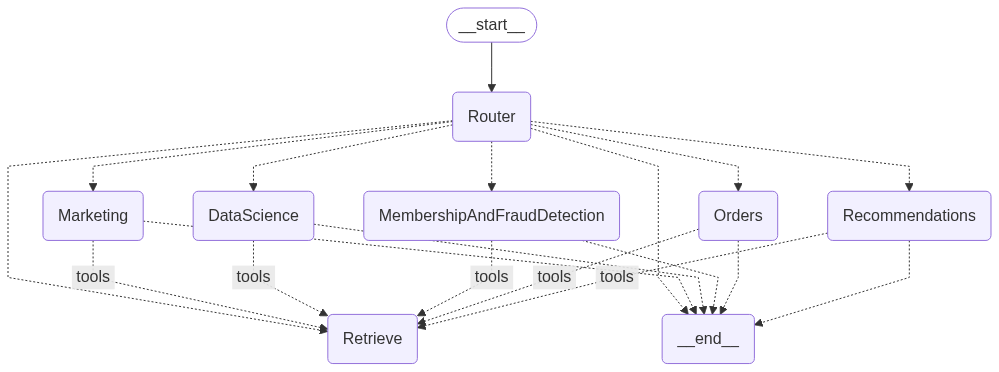

In [29]:
bot.draw_graph()

For the Final Project Phase_2, please see below the recommended guidelines when you start working on this phase:

- Based on the work that you have completed for Phase_1, pick any 3 Agents for the design and development in Phase_2

- Consider reusing/modifying Assignment_3 IPYNB script for the Final Project_Phase_2; you are free to create your own IPYNB script

- Provide the implementation of one user-story from the list of user stories you identified in Phase_1 for every agent of 3 agents you select to work on in Phase_2; these same 3 agents you will provide their complete implementation in Phase_3 for their user-stories you listed in Phase_1

- Your submission for Final Project Phase_2 must demonstrate a working prototype even though it is not a complete implementation for all user-stories; you will provide the complete implementation in Phase_3 for all user-stories  of the 3 agents you select in Phase_2